# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [1]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

# Gurobi module
from gurobipy import *

## Data Extraction

In [2]:
# Load the Excel file into a pandas DataFrame


df_21Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [3]:
# Display the DataFrame
df = df_21Oct
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,NaN,1.0,NaN,01:15:00
1,2,1.0,NaN,NaN,00:00:00
2,3,NaN,1.0,NaN,00:00:00
3,4,1.0,NaN,NaN,00:00:00
4,5,NaN,2.0,NaN,05:25:00
...,...,...,...,...,...
106,107,1.0,NaN,NaN,03:30:00
107,108,2.0,NaN,NaN,05:25:00
108,109,2.0,NaN,NaN,05:25:00
109,110,2.0,NaN,NaN,01:35:00


In [4]:

Passagers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0
transit_times= set()
for group in df.itertuples():
    for j in range(2,5):
        if not pd.isna(group[j]):
            for k in range(int(group[j])):
                Passagers[i] = {'gender': j-2, 'group':group[1], 'transit': float('inf') }
                if group[5].hour*60 + group[5].minute != 0:
                    Passagers[i]['transit'] = group[5].hour*60 + group[5].minute
                    transit_times.add(group[5].hour*60 + group[5].minute)
                if j == 2: number_f+=1
                elif j==3: number_m+=1
                else: number_d+=1

                i+=1    
Passagers

{1: {'gender': 1, 'group': 1, 'transit': 75},
 2: {'gender': 0, 'group': 2, 'transit': inf},
 3: {'gender': 1, 'group': 3, 'transit': inf},
 4: {'gender': 0, 'group': 4, 'transit': inf},
 5: {'gender': 1, 'group': 5, 'transit': 325},
 6: {'gender': 1, 'group': 5, 'transit': 325},
 7: {'gender': 0, 'group': 6, 'transit': inf},
 8: {'gender': 0, 'group': 7, 'transit': 190},
 9: {'gender': 0, 'group': 8, 'transit': 80},
 10: {'gender': 1, 'group': 8, 'transit': 80},
 11: {'gender': 1, 'group': 9, 'transit': 140},
 12: {'gender': 0, 'group': 10, 'transit': inf},
 13: {'gender': 0, 'group': 11, 'transit': 235},
 14: {'gender': 1, 'group': 11, 'transit': 235},
 15: {'gender': 1, 'group': 12, 'transit': 70},
 16: {'gender': 1, 'group': 13, 'transit': inf},
 17: {'gender': 0, 'group': 14, 'transit': inf},
 18: {'gender': 1, 'group': 14, 'transit': inf},
 19: {'gender': 1, 'group': 15, 'transit': 360},
 20: {'gender': 1, 'group': 16, 'transit': 95},
 21: {'gender': 0, 'group': 17, 'transit': 60

In [5]:
Groups = dict()


for i, passager in Passagers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Keys = list(Groups.keys()).copy()


for i in Keys:
        if len(Groups[i]) ==1: del(Groups[i])
Groups

{5: [5, 6],
 8: [9, 10],
 11: [13, 14],
 14: [17, 18],
 17: [21, 22],
 19: [24, 25, 26, 27],
 20: [28, 29, 30, 31],
 21: [32, 33],
 23: [35, 36],
 24: [37, 38],
 27: [41, 42],
 31: [46, 47],
 34: [50, 51],
 35: [52, 53],
 39: [57, 58],
 45: [64, 65],
 51: [71, 72],
 55: [76, 77],
 56: [78, 79],
 57: [80, 81],
 59: [83, 84],
 61: [86, 87],
 63: [89, 90],
 65: [92, 93, 94],
 68: [97, 98],
 71: [101, 102],
 77: [108, 109],
 87: [119, 120],
 92: [125, 126],
 95: [129, 130],
 103: [138, 139],
 104: [140, 141],
 108: [145, 146],
 109: [147, 148],
 110: [149, 150]}

**Définition des paramètres utiles pour la suite**

In [6]:
weight_f = 70
weight_m = 85
weight_d = 92.5
if sum([4*number_d,number_f,number_m]) <= 174 :
    number_of_rows = 29 #modèle d'avion A320
else :
    number_of_rows = 35 #modèle d'avion A321

number_of_columns = 7 # ajout de la colonne qui correspond à l'allée


## Model

Defining the relevant variables of the problem

In [7]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passagers)+1)}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-06


Les variables entières $i_{min}[g]$ et $i_{max}[g]$ (resp. $j_{min}[g]$ et $j_{max}[g]$) correspondent à la valeur de $i$ (resp. la valeur de $j$) la plus petite et la plus grande dans le groupe $g$.

In [8]:
# Variables X_{min}, X_{max}, Y_{min} et Y_{max}
i_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_min({g})') 
            for g in Groups.keys()}

i_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_max({g})') 
            for g in Groups.keys()}

j_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns , name=f'j_min({g})') 
            for g in Groups.keys()}

j_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns  , name=f'j_max({g})') 
            for g in Groups.keys()}

### Les contraintes 

- Contraintes liées à la définition des variables $i_min[g]$, $i_max[g]$, $j_min[g]$, $j_max[g]$

In [9]:


i_min_Passagers_Group = {(g,p) : m.addConstr(i_min[g] <= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

i_max_Passagers_Group = {(g,p) : m.addConstr(i_max[g] >= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_min_Passagers_Group = {(g,p) : m.addConstr(j_min[g] <= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_max_Passagers_Group = {(g,p) : m.addConstr(j_min[g] >= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }



- Every person has one seat

In [10]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passagers)+1) }

- Every seat is allocated to a single person

In [11]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passagers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Personne n'est assis au niveau de l'allée

In [12]:
AISLECONSTDIC = { i : m.addConstr(quicksum([AssignmenVarDict[(i,4,k)]
                                                     for k in range(1, len(Passagers)+1)])
                                                     == 0)
                                                     for i in range(1, number_of_rows + 1)   
}

- Barycenter constraint

In [13]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])

i_f = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])

i_d = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])

j_f = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])

j_d = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [14]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 4)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [15]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 6] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passagers) + 1)
                                               if Passagers[k]['gender'] == 2}

for k in range(1, len(Passagers) + 1):
    if Passagers[k]['gender'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 6]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Objectif Time

- Transit time

In [16]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passagers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passagers)+1)
                      if Passagers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

## Optimisation

In [17]:
m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 5.69                                                    



- Transit time visualization

In [18]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

In [19]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passagers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passagers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passagers[k]['transit']]

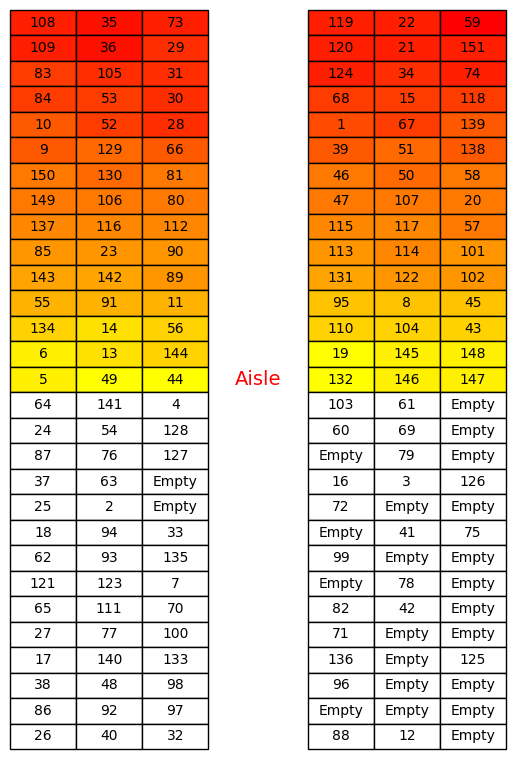

In [20]:

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

In [21]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['gender']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passagers[k]['gender']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'




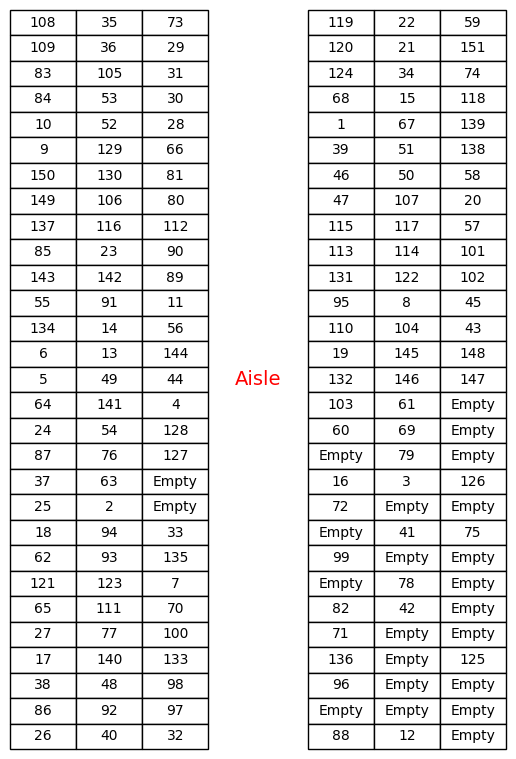

In [22]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Objectif Grouping

- 1st formulation

In [23]:
'''grouping = quicksum([AssignmenVarDict[(i_1, j_1, group[k_1])] * AssignmenVarDict[(i_2, j_2, group[k_2])] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2)) \
                     for group in Groups.values() \
                     for k_1 in range(len(group)) \
                     for k_2 in range(k_1 + 1, len(group)) \
                     for i_1 in range(1, number_of_rows + 1) \
                     for j_1 in range(1, number_of_columns + 1) \
                     for i_2 in range(1, number_of_rows + 1) \
                     for j_2 in range(1, number_of_columns + 1)])

m.setObjective(grouping, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()'''

'grouping = quicksum([AssignmenVarDict[(i_1, j_1, group[k_1])] * AssignmenVarDict[(i_2, j_2, group[k_2])] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2))                      for group in Groups.values()                      for k_1 in range(len(group))                      for k_2 in range(k_1 + 1, len(group))                      for i_1 in range(1, number_of_rows + 1)                      for j_1 in range(1, number_of_columns + 1)                      for i_2 in range(1, number_of_rows + 1)                      for j_2 in range(1, number_of_columns + 1)])\n\nm.setObjective(grouping, GRB.MINIMIZE)\n\nm.params.outputflag = 0 \n\nm.update()'

- 2nd formulation

In [24]:
'''grouping = quicksum([AssignmenVarDict[(i_1, j_1, k_1)] * AssignmenVarDict[(i_2, j_2, k_2)] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2)) \
                     for i_1 in range(1, number_of_rows + 1) \
                     for j_1 in range(1, number_of_columns + 1) \
                     for i_2 in range(1, number_of_rows + 1) \
                     for j_2 in range(1, number_of_columns + 1)\
                        for k_1 in Passagers.keys()
                        for k_2 in Passagers.keys()
                        if Passagers[k_1]['group'] == Passagers[k_2]['group'] and k_1 != k_2])

m.setObjective(grouping, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()'''

"grouping = quicksum([AssignmenVarDict[(i_1, j_1, k_1)] * AssignmenVarDict[(i_2, j_2, k_2)] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2))                      for i_1 in range(1, number_of_rows + 1)                      for j_1 in range(1, number_of_columns + 1)                      for i_2 in range(1, number_of_rows + 1)                      for j_2 in range(1, number_of_columns + 1)                        for k_1 in Passagers.keys()\n                        for k_2 in Passagers.keys()\n                        if Passagers[k_1]['group'] == Passagers[k_2]['group'] and k_1 != k_2])\n\nm.setObjective(grouping, GRB.MINIMIZE)\n\nm.params.outputflag = 0 \n\nm.update()"

**Nouvelle Fonction Objective**

In [25]:
'''
AssignmenVarGrpDict = { (g , i, j , Groups[g][k], Groups[g][l]) : m.addVar(vtype = GRB.BINARY, name=f'Y_{i}_{j}_{Groups[g][k]}_{Groups[g][l]}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns)
                    for g in Groups.keys()
                    for k in range(len(Groups[g]))
                    for l in range(k+1,len(Groups[g]))
                    }
'''

"\nAssignmenVarGrpDict = { (g , i, j , Groups[g][k], Groups[g][l]) : m.addVar(vtype = GRB.BINARY, name=f'Y_{i}_{j}_{Groups[g][k]}_{Groups[g][l]}')\n                    for i in range(1, number_of_rows + 1)\n                    for j in range(1, number_of_columns)\n                    for g in Groups.keys()\n                    for k in range(len(Groups[g]))\n                    for l in range(k+1,len(Groups[g]))\n                    }\n"

In [26]:
'''
GroupingConstDict1 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j,Groups[g][k])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(k+1,len(Groups[g]))
                                                     }

GroupingConstDict2 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j+1,Groups[g][l])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(k+1,len(Groups[g]))
                                                     }

GroupingConstDict3 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] >= 
                                       AssignmenVarDict[(i,j+1,Groups[g][l])] + AssignmenVarDict[(i,j,Groups[g][k])] -1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(k+1,len(Groups[g]))
                                                     }

obj_grouping = quicksum([AssignmenVarGrpDict[(g, i , j, Groups[g][k], Groups[g][l])]
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(k+1,len(Groups[g]))
                                                     
                         ])

m.setObjective(obj_grouping, GRB.MAXIMIZE)
'''





'\nGroupingConstDict1 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j,Groups[g][k])])\n                                                     for i in range(1, number_of_rows + 1)\n                                                     for j in range(1, number_of_columns)\n                                                     for g in Groups.keys()\n                                                     for k in range(len(Groups[g]))\n                                                     for l in range(k+1,len(Groups[g]))\n                                                     }\n\nGroupingConstDict2 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j+1,Groups[g][l])])\n                                                     for i in range(1, number_of_rows + 1)\n                                                     for j in range(1, number_of_columns)\n                                              

**Nouvelle fonction objective**

In [34]:
obj_grouping = quicksum([(i_max[g] - i_min[g]) + 10*(j_max[g] - j_min[g])
                        for g in Groups.keys()])


In [35]:
m.setObjective(obj_grouping, GRB.MINIMIZE)

m.params.outputflag = 0

m.update()


In [36]:
num_vars = m.NumVars
num_vars

30793

## Optimisation


In [37]:
# Set iteration limit
m.setParam(GRB.Param.IterationLimit, 500000)  # Change 1000 to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




In [ ]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }

In [ ]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passagers[k]['group']]
                else:
                    data2[i-1][j-5] = k
                    if Passagers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passagers[k]['group']]

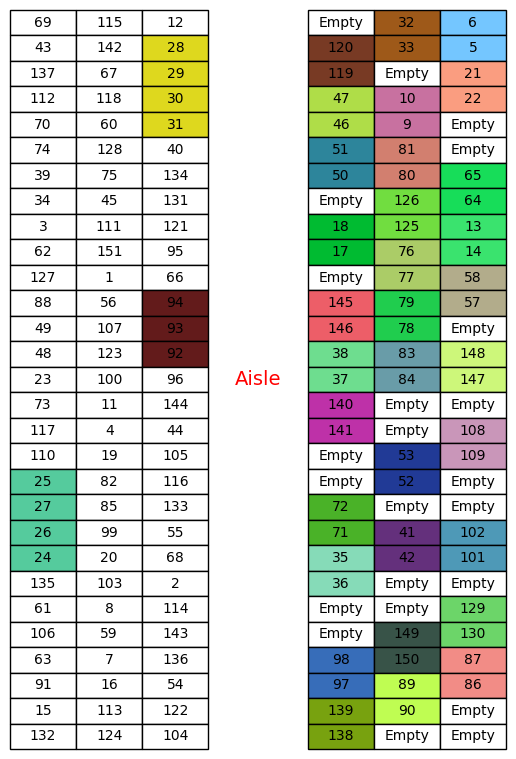

In [ ]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()